In [1]:
# 모듈 import
from datetime import datetime
import numpy as np
import os
import pandas as pd

#from google.colab import drive
#drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/MyDrive/python/python_dong/data_axis_transform1')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

#!pip install torchmetrics
import torchmetrics

#!pip install torchinfo
from torchinfo import summary

import matplotlib.pyplot as plt
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# 1. 데이터 전처리

In [2]:
# data path 지정
raw_data_path = './data/stocknet-dataset/price/raw'

if 'stocknet' in raw_data_path:
    tra_date = '2014-01-02'
    val_date = '2015-08-03'
    tes_date = '2015-10-01'
    end_date = '2015-12-31'
elif 'kdd17' in raw_data_path:
    tra_date = '2007-01-03'
    val_date = '2015-01-02'
    tes_date = '2016-01-04'
    end_date = '2016-12-31'
else:
    print('unexpected path: %s' % raw_data_path)

# os.path.isfile : 파일이 있는지 없는 지 체크
# os.path.join(data_path, fname) : 폴더 디렉터리와 fname(stockname.csv) 붙임
fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

COLUMNS_FEATURE_DATA_V1 = ['open_close_ratio', 'high_close_ratio', 
                           'low_close_ratio', 'close_lastclose_ratio', 
                           'adjclose_lastadjclose_ratio', 'close_ma5_ratio', 
                           'close_ma10_ratio', 'close_ma15_ratio', 'close_ma20_ratio', 
                           'close_ma25_ratio', 'close_ma30_ratio']

ver = 'v1' # ver in ['v1', 'v2']
if ver == 'v1':
    COLUMNS_FEATURE = COLUMNS_FEATURE_DATA_V1

In [3]:
windows = [5,10,15,20,25,30]

def preprocess(df, windows):
   '''
   전처리 함수 역할 : 전체 feature생성하여 df column에 추가
   '''
   data = df
   data['open_close_ratio'] = data['Open'] / data['Close'] - 1
   data['high_close_ratio'] = data['High'] / data['Close'] - 1
   data['low_close_ratio'] = data['Low'] / data['Close'] - 1

   data['close_lastclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'close_lastclose_ratio'] = data['Close'][1:].values / data['Close'][:-1].values - 1

   data['adjclose_lastadjclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'adjclose_lastadjclose_ratio'] = data['Adj Close'][1:].values / data['Adj Close'][:-1].values - 1

   for window in windows:
      data[f'close_ma{window}_ratio'] = data['Adj Close'].rolling(window).mean()/data['Adj Close'] - 1
   
   data['label'] = np.append((data['Close'][1:].values > data['Close'][:-1].values)*1,0)

   return data

In [4]:
feature_data_path = './data/stocknet-dataset/price/feature'

for fname in fnames:
   if not os.path.isfile(os.path.join(feature_data_path,fname)):
      df_raw = pd.read_csv(os.path.join(raw_data_path,fname))
      data = preprocess(df_raw, windows)

      # 폴더 없으면 생성
      try:
         if not os.path.exists(feature_data_path):
            os.makedirs(feature_data_path)
      except OSError:
         print ('Error: Creating directory. ' +  feature_data_path)

      #csv 파일 저장
      data.to_csv(os.path.join(feature_data_path,fname))



# train, validation, test data 나누기

## 1. input data 3차원으로 쌓기
shape = (stock 종류수, date, feature)



요건
1. 모든 티커 데이터의 date가 맞는지?
2. 결측치는 없는지?
3. 티커와 데이터 메치 가능해야함

In [5]:
raw_data_path = './data/stocknet-dataset/price/raw'


tra_data_X = []
tra_data_Y = []
val_data_X = []
val_data_Y = []
test_data_X = []
test_data_Y = []
tickers = []

cnt = 0
fail_cnt = 0

fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

for fname in fnames:

    df = pd.read_csv(os.path.join(raw_data_path,fname))
    data = preprocess(df, windows)

    learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
    tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
    tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

    val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
    val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

    test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
    test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']


    if cnt == 0:
        target_dates = learning_data
    
    print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
    if np.array_equal(target_dates.values, learning_data.values): 
        
        tra_data_X.append(tra_data_X_ticker.values)
        tra_data_Y.append(tra_data_Y_ticker.values)

        val_data_X.append(val_data_X_ticker.values)
        val_data_Y.append(val_data_Y_ticker.values)
        
        test_data_X.append(test_data_X_ticker.values)
        test_data_Y.append(test_data_Y_ticker.values)

        tickers.append(fname)
    else : 
        fail_cnt += 1
    
    cnt += 1

print(cnt, len(fnames))
print('fail_cnt :', fail_cnt)

# 마지막에 index 종목 넣기
raw_data_index_path = './data/stocknet-dataset/price/raw/index'

fname = os.listdir(raw_data_index_path)[0]

df = pd.read_csv(os.path.join(raw_data_index_path,fname))
data = preprocess(df, windows)

learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']

print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
if np.array_equal(target_dates.values, learning_data.values):
    
    tra_data_X.append(tra_data_X_ticker.values)
    # tra_data_Y.append(tra_data_Y_ticker.values)

    val_data_X.append(val_data_X_ticker.values)
    # val_data_Y.append(val_data_Y_ticker.values)
    
    test_data_X.append(test_data_X_ticker.values)
    # test_data_Y.append(test_data_Y_ticker.values)

    tickers.append(fname)

# tra_data_X

ticker : AAPL.csv, date check : True
ticker : ABB.csv, date check : True
ticker : ABBV.csv, date check : True
ticker : AEP.csv, date check : True
ticker : AGFS.csv, date check : False
ticker : AMGN.csv, date check : True
ticker : AMZN.csv, date check : True
ticker : BA.csv, date check : True
ticker : BABA.csv, date check : False
ticker : BAC.csv, date check : True
ticker : BBL.csv, date check : True
ticker : BCH.csv, date check : True
ticker : BHP.csv, date check : True
ticker : BP.csv, date check : True
ticker : BRK-A.csv, date check : True
ticker : BSAC.csv, date check : True
ticker : BUD.csv, date check : True
ticker : C.csv, date check : True
ticker : CAT.csv, date check : True
ticker : CELG.csv, date check : True
ticker : CHL.csv, date check : True
ticker : CHTR.csv, date check : True
ticker : CMCSA.csv, date check : True
ticker : CODI.csv, date check : True
ticker : CSCO.csv, date check : True
ticker : CVX.csv, date check : True
ticker : D.csv, date check : True
ticker : DHR.csv,

In [6]:
def list_to_tensor(list_):
    return torch.Tensor(np.array(list_))

In [7]:
tensor_tra_data_X = list_to_tensor(tra_data_X)
tensor_tra_data_Y = list_to_tensor(tra_data_Y).view((len(tra_data_Y),-1,1))
tensor_val_data_X = list_to_tensor(val_data_X)
tensor_val_data_Y = list_to_tensor(val_data_Y).view((len(val_data_Y),-1,1))
tensor_test_data_X = list_to_tensor(test_data_X)
tensor_test_data_Y = list_to_tensor(test_data_Y).view((len(test_data_Y),-1,1))

## Hyperparameter setting

In [8]:
w = 10 # window size w in {10, 15}
beta = 0.01 # market context weight beta in {0.01, 0.1, 1}
h = 64 # hidden layer size h in {64, 128}
learning_rate = 0.001 # in {0.001, 0.0001}
lambda_1 = 1 # selective regularzation lambda = 1
drop_rate = 0.15
feature_size = len(COLUMNS_FEATURE)

In [9]:
class Feature_transformation_layer(nn.Module):
    """Feature transformation layer in DTML"""

    def __init__(self, feature_size, h):
        super(Feature_transformation_layer, self).__init__()
        self.feature_size = feature_size
        self.h = h

        self.linear = nn.Linear(self.feature_size, self.h)
    
    def forward(self, X):
        output = torch.tanh(self.linear(X))
        return output

In [10]:
def layer_normalization(tensor):
    h = tensor.size()[-1]
    return (tensor - torch.std_mean(tensor, dim=1, unbiased=False)[1].repeat((h,1)).transpose(-2,-1))/torch.std_mean(tensor, dim=1, unbiased=False)[0].repeat((h,1)).transpose(-2,-1)

In [11]:
class Nonlinear_transformation(nn.Module):
    """Nonlinear transformation in DTML"""

    def __init__(self, h):
        super(Nonlinear_transformation, self).__init__()
        self.h = h


        self.mlp1 = nn.Linear(self.h, self.h * 4)
        self.mlp2 = nn.Linear(self.h * 4, h)
    
    def forward(self, H, H_tilda, on_train=True):
        H_p = H + H_tilda
        H_p = self.mlp1(H_p)
        H_p = nn.ReLU()(H_p)
        H_p = self.mlp2(H_p)
        H_p = H + H_tilda + H_p
        H_p = nn.Tanh()(H_p)

        # dropout and layer normalization
        if on_train == True:
            H_p = nn.Dropout(p=drop_rate)(H_p)
        H_p = layer_normalization(H_p)
        return H_p

In [12]:
class Final_prediction(nn.Module):
    """final prediction in DTML"""

    def __init__(self, h):
        super(Final_prediction, self).__init__()
        self.h = h

        self.pred_linear = nn.Linear(h,1)
    
    def forward(self, H_p):
        y_hat = self.pred_linear(H_p)
        y_hat = nn.Sigmoid()(y_hat).view((-1))

        return y_hat

In [17]:
class DTML(nn.Module):
    ''' DTML '''

    def __init__(self, X, y, w, h, beta, vali_X, vali_y, test_X, test_y,
                 batch_size,
                 learning_rate, epochs):
        """ Initialize """
        super(DTML, self).__init__()
        self.X = X
        self.y = y
        self.vali_X = vali_X
        self.vali_y = vali_y
        self.test_X = test_X
        self.test_y = test_y
        self.w = w
        self.h = h
        self.beta = beta
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.train_timesteps = train_timesteps = int(X.size()[1]) - w

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator : ", self.device)

        self.Feature_transformation_layer = Feature_transformation_layer(feature_size=self.X.size()[-1],
                                                                         h=self.h)
        
        # 티커별로 lstm 층 개별로 만들기
        for i in range(self.X.size()[0]): # 마지막은 index용 lstm
            self._modules['lstm_{}'.format(i)] = nn.LSTM(input_size = self.h, hidden_size=self.h, batch_first=True)
        
        # ticker별로 linear layer 생성
        for i in range(self.X.size()[0]):
            self._modules['ContextNormalLinearLayer_{}'.format(i)] = nn.Linear(h, h)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.h, num_heads=8, dropout=drop_rate)
        self.query_layer = nn.Linear(self.h, self.h)
        self.key_layer = nn.Linear(self.h, self.h)
        self.value_layer = nn.Linear(self.h, self.h)

        self.Nonlinear_transformation = Nonlinear_transformation(h=self.h)

        self.Final_prediction = Final_prediction(h=self.h)

        # Loss funciton
        self.criterion = nn.BCELoss()

        self.optimizer = optim.Adam(params=self.parameters(), lr=self.learning_rate)

    def window_(self, tensor, time_idx, window_size):
        # tensor size = (ticker_number, dates, feature_size)    
        return tensor[:, time_idx:time_idx + self.w, :]


    def train(self):
        mode = 'train'
        if mode == 'train':
            X = self.X
            y_data = self.y
            epochs = self.epochs
        elif mode == 'validation':
            X = self.vali_X
            y_data = self.vali_y
            epochs = 1
        
        elif mode == 'test':
            X = self.test_X
            y_data = self.test_y
            epochs = 1

        else:
            print('유효하지 않는 mode입니다.')
            

        timesteps = int(X.size()[1]) - w

        """training process"""
        # epoch당 iteration 수
        iter_per_epoch = int(np.ceil(timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.iter_losses = np.zeros(epochs * iter_per_epoch)
        self.iter_acc = np.zeros(epochs * iter_per_epoch)
        self.iter_mcc = np.zeros(epochs * iter_per_epoch)
        self.iter_precision = np.zeros(epochs * iter_per_epoch)
        self.return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.index_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.com_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.index_com_return_rate = np.zeros((epochs, timesteps))

        # epoch당 loss
        self.epoch_losses = np.zeros(epochs)
        self.epoch_acc = np.zeros(epochs)
        self.epoch_mcc = np.zeros(epochs)
        self.epoch_precision = np.zeros(epochs)

        # epoch당 loss (Validation)
        self.vali_epoch_losses = np.zeros(epochs)
        self.vali_epoch_acc = np.zeros(epochs)
        self.vali_epoch_mcc = np.zeros(epochs)
        self.vali_epoch_precision = np.zeros(epochs)

        vali_timesteps = int(self.vali_X.size()[1]) - w

        """training process"""
        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.vali_iter_losses = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_acc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_mcc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_precision = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_com_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_com_return_rate = np.zeros((epochs, vali_timesteps))

        train_n_iter = 0

        for epoch in range(self.epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(X)

            while (time_idx < timesteps):
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tra_data_Y_w = self.window_(y_data, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((X.size()[0], self.h))
                for i in range(self.X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(X.size()[0], self.h)
                for i in range(X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외


                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]
                #Q = self.query_layer(H)
                #K = self.key_layer(H)
                #V = self.value_layer(H)

                # S 생성
                #S = torch.matmul(Q, K.transpose(-2,-1))
                #S = S/math.sqrt(h)
                #S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                #H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation --> attention후, drop-out 하라고 논문에 있음
                #H_tilda = nn.Dropout(p=drop_rate)(H_tilda) -> multihead에 dropout 포함되어있습니다.
                H_tilda = layer_normalization(H_tilda)

                if mode == 'train':
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=True)
                else:
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False)

                y_hat = self.Final_prediction(H_p)
                y = tra_data_Y_w[:,w-1,:].view((-1))

                if mode == 'train':
                    self.optimizer.zero_grad()

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                
                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                index_return_rate = X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                if mode == 'train':
                    loss_reg.backward(retain_graph=True)
                    self.optimizer.step()
              

                self.iter_losses[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.iter_acc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = acc
                self.iter_mcc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.iter_precision[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = precision
                self.return_rate[epoch, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.index_return_rate[epoch, time_idx] = index_return_rate
                self.com_return_rate[epoch, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.index_com_return_rate[epoch, time_idx] = index_com_return_rate # batch_size 적용하면 수정해야함    

                '''
                if time_idx % 1000 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision,
                          "return_rate", return_rate,
                          "com_return_rate", com_return_rate)
                '''
                

                time_idx += self.batch_size
                train_n_iter += 1                

                if train_n_iter % 100 == 0 and train_n_iter != 0:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                
                ######### 공통부분 끝, 데이터 수집 시작

            self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_acc[epoch] = np.mean(self.iter_acc[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_mcc[epoch] = np.mean(self.iter_mcc[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_precision[epoch] = np.mean(self.iter_precision[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(timesteps), self.com_return_rate[epoch][:timesteps], label='portfolio')
            plt.plot(range(timesteps), self.index_com_return_rate[0][ : timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.iter_losses[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.iter_acc[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()

            if epoch % 1 == 0:
                plt.subplot(2,1,1)
                plt.plot(range(epoch + 1), self.epoch_losses[:epoch + 1], label=mode)
                plt.legend(loc='upper left')
                plt.ylabel('loss_reg')

                plt.subplot(2,1,2)
                plt.plot(range(epoch + 1), self.epoch_acc[:epoch + 1], label=mode)
                plt.legend(loc='upper left')
                plt.ylabel('acc')

                plt.show()

            if epoch % 1 == 0:
                print("Epochs : ", epoch, "Iterations : ", train_n_iter,
                      "Loss : ", self.epoch_losses[epoch],
                      "ACC : ", self.epoch_acc[epoch],
                      "MCC : ", self.epoch_mcc[epoch],
                      "Precision : ", self.epoch_precision[epoch])
            
            if epoch % 1 == 0:
                self.validation(e=epoch)




            if epoch % 1 == 0:
                plt.subplot(2,1,1)
                plt.plot(range(epoch + 1), self.vali_epoch_losses[:epoch + 1], label='validation')
                plt.legend(loc='upper left')
                plt.ylabel('loss_reg')

                plt.subplot(2,1,2)
                plt.plot(range(epoch + 1), self.vali_epoch_acc[:epoch + 1], label='validation')
                plt.legend(loc='upper left')
                plt.ylabel('acc')

                plt.show()
    
    def validation(self , e):
        mode = 'validation'
        if mode == 'train':
            print('mode :', mode)
            X = self.X
            y_data = self.y
            epochs = self.epochs
        elif mode == 'validation':
            print('mode :', mode)
            X = self.vali_X
            y_data = self.vali_y
            epochs = 1
        
        elif mode == 'test':
            print('mode :', mode)
            X = self.test_X
            y_data = self.test_y
            epochs = 1

        else:
            print('유효하지 않는 mode입니다.')
            
        
        vali_timesteps = int(X.size()[1]) - w

        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        '''
        """training process"""
        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.vali_iter_losses = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_acc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_mcc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_precision = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_com_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_com_return_rate = np.zeros((epochs, vali_timesteps))
        '''
        '''
        # epoch당 loss
        self.vali_epoch_losses = np.zeros(epochs)
        self.vali_epoch_acc = np.zeros(epochs)
        self.vali_epoch_mcc = np.zeros(epochs)
        self.vali_epoch_precision = np.zeros(epochs)
        '''

        vali_n_iter = 0

        for epoch in range(epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(X)

            while (time_idx < vali_timesteps):
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tra_data_Y_w = self.window_(y_data, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((X.size()[0], self.h))
                for i in range(self.X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(X.size()[0], self.h)
                for i in range(X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외


                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]
                #Q = self.query_layer(H)
                #K = self.key_layer(H)
                #V = self.value_layer(H)

                # S 생성
                #S = torch.matmul(Q, K.transpose(-2,-1))
                #S = S/math.sqrt(h)
                #S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                #H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation --> attention후, drop-out 하라고 논문에 있음
                #H_tilda = nn.Dropout(p=drop_rate)(H_tilda) -> multihead에 dropout 포함되어있습니다.
                H_tilda = layer_normalization(H_tilda)

                if mode == 'train':
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=True)
                else:
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False)

                y_hat = self.Final_prediction(H_p)
                y = tra_data_Y_w[:,w-1,:].view((-1))

                if mode == 'train':
                    self.optimizer.zero_grad()

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                
                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                index_return_rate = X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                if mode == 'train':
                    loss_reg.backward(retain_graph=True)
                    self.optimizer.step()
              

                self.vali_iter_losses[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.vali_iter_acc[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = acc
                self.vali_iter_mcc[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.vali_iter_precision[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = precision
                self.vali_return_rate[e, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.vali_index_return_rate[e, time_idx] = index_return_rate
                self.vali_com_return_rate[e, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.vali_index_com_return_rate[e, time_idx] = index_com_return_rate # batch_size 적용하면 수정해야함    

                '''
                if time_idx % 1000 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision,
                          "return_rate", return_rate,
                          "com_return_rate", com_return_rate)
                '''
                

                time_idx += self.batch_size
                vali_n_iter += 1                

                '''
                if train_n_iter % 100 == 0 and train_n_iter != 0:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                '''
                
                ######### 공통부분 끝, 데이터 수집 시작

            self.vali_epoch_losses[e] = np.mean(self.vali_iter_losses[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_acc[e] = np.mean(self.vali_iter_acc[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_mcc[e] = np.mean(self.vali_iter_mcc[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_precision[e] = np.mean(self.vali_iter_precision[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(vali_timesteps), self.vali_com_return_rate[e][:vali_timesteps], label='portfolio')
            plt.plot(range(vali_timesteps), self.vali_index_com_return_rate[0][ : vali_timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(e * vali_iter_per_epoch + time_idx / self.batch_size)), self.vali_iter_losses[:int(e * vali_iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(e * vali_iter_per_epoch + time_idx / self.batch_size)), self.vali_iter_acc[:int(e * vali_iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()



            if epoch % 1 == 0:
                print("Epochs : ", e, "Iterations : ", vali_n_iter,
                      "Loss : ", self.vali_epoch_losses[e],
                      "ACC : ", self.vali_epoch_acc[e],
                      "MCC : ", self.vali_epoch_mcc[e],
                      "Precision : ", self.vali_epoch_precision[e])
        
    
    def test(self):
        
        timesteps = int(self.test_X.size()[1]) - w
        epochs = 1
        # epoch당 iteration 수
        iter_per_epoch = int(np.ceil(timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.test_iter_losses = np.zeros(epochs * iter_per_epoch)
        self.test_iter_acc = np.zeros(epochs * iter_per_epoch)
        self.test_iter_mcc = np.zeros(epochs * iter_per_epoch)
        self.test_iter_precision = np.zeros(epochs * iter_per_epoch)
        self.test_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.test_index_return_rate = np.zeros((epochs, timesteps))
        self.test_com_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.test_index_com_return_rate = np.zeros((epochs, timesteps))

        # epoch당 loss
        self.test_epoch_losses = np.zeros(epochs)
        self.test_epoch_acc = np.zeros(epochs)
        self.test_epoch_mcc = np.zeros(epochs)
        self.test_epoch_precision = np.zeros(epochs)

        n_iter = 0

        for epoch in range(epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(self.test_X)

            while (time_idx < timesteps): # test끝으로 바꿔야함
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tes_data_Y_w = self.window_(self.test_y, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((self.test_X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(self.test_X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((self.test_X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(self.test_X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((self.test_X.size()[0], self.h))
                for i in range(self.test_X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(self.test_X.size()[0], self.h)
                for i in range(self.test_X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외

                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]

                # Q = self.query_layer(H)
                # K = self.key_layer(H)
                # V = self.value_layer(H)

                # S 생성
                # S = torch.matmul(Q, K.transpose(-2,-1))
                # S = S/math.sqrt(h)
                # S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                # H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation
                # H_tilda = nn.Dropout(p=drop_rate)(H_tilda)
                H_tilda = layer_normalization(H_tilda)


                H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False) # dropout을 없애야한다!
                
                y_hat = self.Final_prediction(H_p)
                # print("y_hat :", y_hat)
                y = tes_data_Y_w[:,w-1,:].view((-1))

                # self.optimizer.zero_grad()
                # test에서는 학습할 필요 없어요

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                # loss_reg 달라짐
                # print("loss : ", loss_reg)

                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = self.test_X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                index_return_rate = self.test_X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                # test에서는 학습할 필요 없어요
                # loss_reg.backward(retain_graph=True)
                # self.optimizer.step()

                self.test_iter_losses[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.test_iter_acc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = acc
                self.test_iter_mcc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.test_iter_precision[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = precision
                self.test_return_rate[epoch, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.test_index_return_rate[epoch, time_idx] = index_return_rate
                self.test_com_return_rate[epoch, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.test_index_com_return_rate[epoch, time_idx] = index_com_return_rate

                if time_idx % 100 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision)

                time_idx += self.batch_size
                n_iter += 1

                self.test_epoch_losses[epoch] = np.mean(self.test_iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_acc[epoch] = np.mean(self.test_iter_acc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_mcc[epoch] = np.mean(self.test_iter_mcc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_precision[epoch] = np.mean(self.test_iter_precision[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                # 수익률 계산
                # 수정종가에 매수, 익일 수정종가에 매도
                # adjclose_lastadjclose_ratio 으로 계산 (5번째 있는 column / index는 4)
                # Weight = 동일가중
                # 오를 확률이 제일 높은 3개 Ticker 매수 후, 익일 매도

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(timesteps), self.test_com_return_rate[0][ : timesteps], label="Portfolio")
            plt.plot(range(timesteps), self.test_index_com_return_rate[0][ : timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.test_iter_losses[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label='test')
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.test_iter_acc[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label='test')
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()    


            if epoch % 10 == 0:
                print("Epochs : ", epoch, "Iterations : ", n_iter,
                      "Loss : ", self.test_epoch_losses[epoch],
                      "ACC : ", self.test_epoch_acc[epoch],
                      "MCC : ", self.test_epoch_mcc[epoch],
                      "Precision : ", self.test_epoch_precision[epoch])


                

In [18]:
model = DTML(
    X=tensor_tra_data_X,
    y=tensor_tra_data_Y,
    vali_X = tensor_val_data_X,
    vali_y = tensor_val_data_Y,
    test_X = tensor_test_data_X,
    test_y=tensor_test_data_Y,
     w=w, h=h, batch_size=1, beta = 0.01,
     learning_rate=learning_rate, epochs=2)

==> Use accelerator :  cpu


In [19]:
summary(model)

Layer (type:depth-idx)                             Param #
DTML                                               --
├─Feature_transformation_layer: 1-1                --
│    └─Linear: 2-1                                 768
├─LSTM: 1-2                                        33,280
├─LSTM: 1-3                                        33,280
├─LSTM: 1-4                                        33,280
├─LSTM: 1-5                                        33,280
├─LSTM: 1-6                                        33,280
├─LSTM: 1-7                                        33,280
├─LSTM: 1-8                                        33,280
├─LSTM: 1-9                                        33,280
├─LSTM: 1-10                                       33,280
├─LSTM: 1-11                                       33,280
├─LSTM: 1-12                                       33,280
├─LSTM: 1-13                                       33,280
├─LSTM: 1-14                                       33,280
├─LSTM: 1-15            

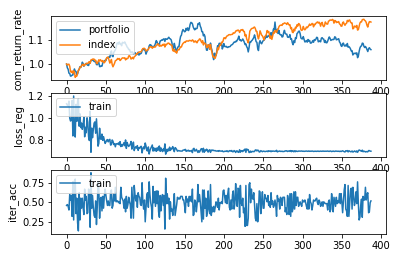

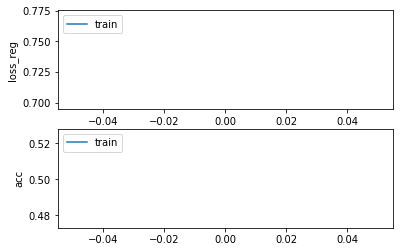

Epochs :  0 Iterations :  388 Loss :  0.7349799091053992 ACC :  0.5005154790567983 MCC :  0.00576908028019669 Precision :  0.514249048018156
mode : validation


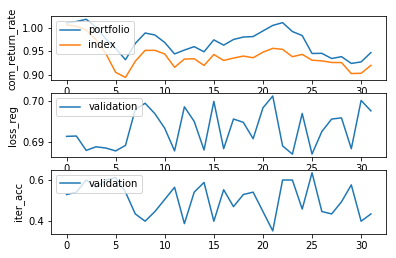

Epochs :  0 Iterations :  32 Loss :  0.6931796576827765 ACC :  0.5073529575020075 MCC :  nan Precision :  0.44806163024622947


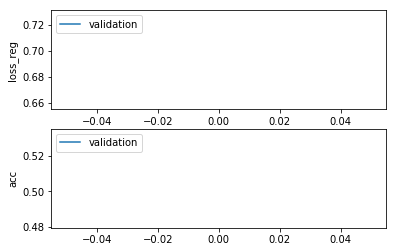

KeyboardInterrupt: 

In [20]:
model.train()

In [ ]:
model.test()

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.train() # dropout 없음, epochs = 5

In [ ]:
model.train() # dropout 0.15 적용

In [ ]:
model.test()

In [ ]:
model.test()

In [ ]:
model.train()

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.epoch_losses

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.return_rate.shape

In [ ]:
ㄴmodel.train()

In [ ]:
model.train()